集成学习和随机森林
如果你随机向几千个人询问一个复杂问题，然后汇总他们的回
答。在许多情况下，你会发现，这个汇总的回答比专家的回答还要
好。这被称为群体智慧。同样，如果你聚合一组预测器（比如分类器
或回归器）的预测，得到的预测结果也比最好的单个预测器要好。这
样的一组预测器，我们称为集成，所以这种技术，也被称为集成学
习，而一个集成学习的算法则被称为集成方法。

例如，你可以训练一组决策树分类器，每一棵树都基于训练集不
同的随机子集进行训练。做出预测时，你只需要获得所有树各自的预
测，然后给出得票最多的类别作为预测结果（见第6章最后一道练
习）。这样一组决策树的集成被称为随机森林，尽管很简单，但它是
迄今可用的最强大的机器学习算法之一

投票分类器
假设你已经训练好了一些分类器，每个分类器的准确率约为
80%。大概包括：一个逻辑回归分类器、一个SVM分类器、一个随机
森林分类器、一个K-近邻分类器，或许还有更多

这时，要创建出一个更好的分类器，最简单的办法就是聚合每个
分类器的预测，然后将得票最多的结果作为预测类别。这种大多数投
票分类器被称为硬投票分类器

你会多少有点惊讶地发现，这个投票法分类器的准确率通常比集
成中最好的分类器还要高。事实上，即使每个分类器都是弱学习器
（意味着它仅比随机猜测好一点），通过集成依然可以实现一个强学
习器（高准确率），只要有足够大数量并且足够多种类的弱学习器就
可以。

In [1]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

这怎么可能呢？下面这个类比可以帮助你掀开这层神秘面纱。假
设你有一个略微偏倚的硬币，它有51%的可能正面数字朝上，49%的
可能背面花朝上。如果你掷1000次，你大致会得到差不多510次数字
和490次花，所以正面是大多数。而如果你做数学题，你会发现，“在
1000次投掷后，大多数为正面朝上”的概率接近75%。投掷硬币的次
数越多，这个概率越高（例如，投掷10000次后，这个概率攀升至
97%）。这是因为大数定理导致的：随着你不断投掷硬币，正面朝上
的比率越来越接近于正面的概率（51%）。图7-3显示了10条偏倚硬
币的投掷结果。可以看出随着投掷次数的增加，正面的比率逐渐接近
51%，最终所有10条线全都接近51%，并且始终位于50%以上。

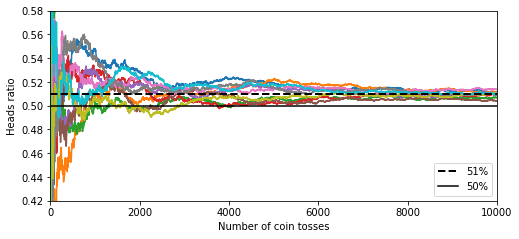

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
# save_fig("law_of_large_numbers_plot")
plt.show()

同样，假设你创建了一个包含1000个分类器的集成，每个分类器
都只有51%的几率是正确的（几乎没比随机猜测强多少）。如果你以
大多数投票的类别作为预测结果，你可以期待的准确率高达75%。但
是，这基于的前提是：所有的分类器都是完全独立的，彼此的错误毫
不相关。显然这是不可能的，因为它们都是在相同的数据上训练的。
它们很可能会犯相同的错误，所以也会有很多次大多数投给了错误的
类别，导致集成的准确率有所降低。

当预测器尽可能互相独立时，集成方法的效果最优。获得多
种分类器的方法之一就是使用不同的算法进行训练。这会增加它们犯
不同类型错误的机会，从而提升集成的准确率。

下面的代码用Scikit-Learn创建并训练一个投票分类器，由三种不
同的分类器组成（训练集是卫星数据集，见第5章）

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

看看每个分类器在测试集上的准确率

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


你看到了，投票分类器略胜于所有单个分类器。

如果所有分类器都能够估算出类别的概率（即有
predict_proba（）方法），那么你可以将概率在所有单个分类器上平
均，然后让Scikit-Learn给出平均概率最高的类别作为预测。这被称为
软投票法。通常来说，它比硬投票法的表现更优，因为它给予那些高
度自信的投票更高的权重。而所有你需要做的就是用voting="soft"代
替voting="hard"，并确保所有分类器都可以估算出概率。默认情况
下，SVC类是不行的，所以你需要将其超参数probability设置为
True（这会导致SVC使用交叉验证来估算类别概率，减慢训练速度，
并会添加predict_proba（）方法）。如果修改上面代码为使用软投
票，你会发现投票分类器的准确率达到91%以上

In [7]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


bagging和pasting

前面提到，获得不同种类分类器的方法之一是使用不同的训练算
法。还有另一种方法是每个预测器使用的算法相同，但是在不同的训
练集随机子集上进行训练。采样时如果将样本放回，这种方法叫作
bagging [1] （bootstrap aggregating [2] 的缩写，也叫自举汇聚法）；采样
时样本不放回，这种方法则叫用pasting

换句话说，bagging和pasting都允许训练实例在多个预测器中被
多次采样，但是只有bagging允许训练实例被同一个预测器多次采
样。

一旦预测器训练完成，集成就可以通过简单地聚合所有预测器的
预测，来对新实例做出预测。聚合函数通常是统计法（即最多数的预
测好比硬投票分类器一样）用于分类，或是平均法用于回归。每个预
测器单独的偏差都高于在原始训练集上训练的偏差，但是通过聚合，
同时降低了偏差和方差。 [4] 总体来说，最终结果是，与直接在原始训
练集上训练的单个预测器相比，集成的偏差相近，但是方差更低。

Scikit-Learn的bagging和pasting
Scikit-Learn提供了一个简单的API，可用BaggingClassifier类进行
bagging和pasting（或BaggingRegressor用于回归）。以下代码训练了
一个包含500个决策树分类器的集成， [5] 每次随机从训练集中采样100
个训练实例进行训练，然后放回（这是一个bagging的示例，如果你
想使用pasting，只需要设置bootstrap=False即可）。参数n_jobs用来指
示Scikit-Learn用多少CPU内核进行训练和预测（-1表示让Scikit-Learn
使用所有可用内核）：

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


如果基础分类器能够估算类别概率（也就是具备
predict_proba（）方法），比如决策树分类器，那么BaggingClassifier
自动执行的就是软投票法而不是硬投票法。

In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


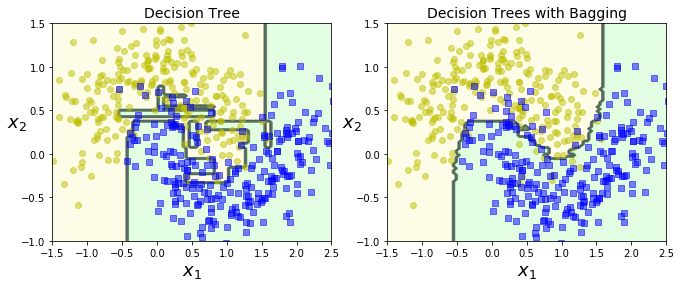

In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

#%%

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
# save_fig("decision_tree_without_and_with_bagging_plot")
'''
图7-5：单个的决策树与500个决策树的bagging集成对比
'''
plt.show()

图7-5比较了两种决策边界，一个是单个的决策树，一个是由500
个决策树组成的bagging集成（来自前面的代码），均在卫星数据集
上训练完成。可以看出，集成预测的泛化效果很可能会比单独的决策
树要好一些：二者偏差相近，但是集成的方差更小（两边训练集上的
错误数量差不多，但是集成的决策边界更规则）。

由于自助法给每个预测器的训练子集引入了更高的多样性，所以
最后bagging比pasting的偏差略高，但这也意味着预测器之间的关联
度更低，所以集成的方差降低。总之，bagging生成的模型通常更
好，这也就是为什么它更受欢迎。但是，如果你有充足的时间和CPU
资源，可以使用交叉验证来对bagging和pasting的结果进行评估，再
做出最合适的选择。

包外评估

对于任意给定的预测器，使用bagging，有些实例可能会被采样
多次，而有些实例则可能根本不被采样。BaggingClassifier默认采样m
个训练实例，然后放回样本（bootstrap=True），m是训练集的大小。
这意味着对于每个预测器来说，平均只对63%的训练实例进行采
样。 [6] 剩余37%未被采样的训练实例称为包外（oob）实例。注意，对
所有预测器来说，这是不一样的37%。
既然预测器在训练的时候从未见过这些包外实例，正好可以用这
些实例进行评估，从而不需要单独的验证集或是交叉验证。将每个预
测器在其包外实例上的评估结果进行平均，你就可以得到对集成的评
估。

Scikit-Learn中，创建BaggingClassifier时，设置
oob_score=True，就可以请求在训练结束后自动进行包外评估

In [21]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [25]:
from sklearn.metrics import accuracy_score
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_
y_pred = bag_clf.predict(X_test)

In [23]:
'''
测试集上的准确率为93.6%——非常接近！
'''
accuracy_score(y_test, y_pred)

0.92000000000000004

In [24]:
'''
每个训练实例的包外决策函数也可以通过变量
oob_decision_function_获得。本例中（基础预测器具备
predict_proba（）方法），决策函数返回的是每个实例的类别概率。
例如，包外评估估计，第二个训练实例有60.6%的概率属于正类（以
及39.4%的概率属于负类）。
'''
bag_clf.oob_decision_function_

array([[ 0.34536082,  0.65463918],
       [ 0.41621622,  0.58378378],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.07303371,  0.92696629],
       [ 0.4       ,  0.6       ],
       [ 0.01530612,  0.98469388],
       [ 1.        ,  0.        ],
       [ 0.99428571,  0.00571429],
       [ 0.77297297,  0.22702703],
       [ 0.        ,  1.        ],
       [ 0.75842697,  0.24157303],
       [ 0.82539683,  0.17460317],
       [ 0.96610169,  0.03389831],
       [ 0.06358382,  0.93641618],
       [ 0.00574713,  0.99425287],
       [ 0.96590909,  0.03409091],
       [ 0.94152047,  0.05847953],
       [ 0.9787234 ,  0.0212766 ],
       [ 0.03508772,  0.96491228],
       [ 0.36612022,  0.63387978],
       [ 0.8972973 ,  0.1027027 ],
       [ 1.        ,  0.        ],
       [ 0.96590909,  0.03409091],
       [ 0.        ,  1.        ],
       [ 0.99470899,  0.00529101],
       [ 1.        ,  0.        ],
       [ 0.        ,

Random Patches和随机子空间
BaggingClassifier也支持对特征进行抽样，这通过两个超参数控
制：max_features和bootstrap_features。它们的工作方式跟
max_samples和bootstrap相同，只是抽样对象不再是实例，而是特
征。因此，每个预测器将用输入特征的随机子集进行训练。
这对于处理高维输入（例如图像）特别有用。对训练实例和特征
都进行抽样，被称为Random  Patches方法。 [1] 而保留所有训练实例
（即bootstrap=False并且max_samples=1.0）但是对特征进行抽样（即
bootstrap_features=True并且/或max_features<1.0），这被称为随机子
空间法。 [2]
对特征抽样给预测器带来更大的多样性，所以以略高一点的偏差
换取了更低的方差。

随机森林
前面已经提到，随机森林（http://goo.gl/zVOGQ1） [1] 是决策树的
集成，通常用bagging（有时也可能是pasting）方法训练，训练集大
小通过max_samples来设置。除了先构建一个BaggingClassifier然后将
结果传输到DecisionTreeClassifier，还有一种方法就是使用
RandomForestClassifier类，这种方法更方便，对决策树更优化 [2] （同
样，对于回归任务也有一个RandomForestRegressor类）。

In [26]:
'''
以下代码使
用所有可用的CPU内核，训练了一个拥有500棵树的随机森林分类器
（每棵树限制为最多16个叶节点）：

'''

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

除了少数例外，RandomForestClassifier具有DecisionTreeClassifier
的所有超参数，以及BaggingClassifier的所有超参数，前者用来控制
树的生长，后者用来控制集成本身

随机森林在树的生长上引入了更多的随机性：分裂节点时不再是
搜索最好的特征（参见第6章），而是在一个随机生成的特征子集里
搜索最好的特征。这导致决策树具有更大的多样性，（再一次）用更
高的偏差换取更低的方差，总之，还是产生了一个整体性能更优的模
型。

下面的BaggingClassifier大致与前面的RandomForestClassifier相
同：

In [27]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

极端随机树
如前所述，随机森林里单棵树的生长过程中，每个节点在分裂时
仅考虑到了一个随机子集所包含的特征。如果我们对每个特征使用随
机阈值，而不是搜索得出的最佳阈值（如常规决策树），则可能让决
策树生长得更加随机。
这种极端随机的决策树组成的森林，被称为极端随机树集成 [4] （或简称Extra-Trees）。同样，它也
是以更高的偏差换取了更低的方差。极端随机树训练起来比常规随机
森林要快很多，因为在每个节点上找到每个特征的最佳阈值是决策树
生长中最耗时的任务之一。
使用Scikit-Learn的ExtraTreesClassifier可以创建一个极端随机树
分类器。它的API与RandomForestClassifier相同。同理，
ExtraTreesRegressor与RandomForestRegressor的API也相同。

通常来说，很难预先知道一个RandomForestClassifier是否会
比一个ExtraTreesClassifier更好或是更差。唯一的方法是两种都尝试
一遍，然后使用交叉验证（还需要使用网格搜索调整超参数）进行比
较。

特征重要性
最后，如果你查看单个决策树会发现，重要的特征更可能出现在
靠近根节点的位置，而不重要的特征通常出现在靠近叶节点的位置
（甚至根本不出现）。因此，通过计算一个特征在森林中所有树上的
平均深度，可以估算出一个特征的重要程度。Scikit-Learn在训练结束
后自动计算每个特征的重要性。通过变量feature_importances_你就可
以访问到这个计算结果。

例如，以下代码在鸢尾花数据集（见第4
章）上训练了一个RandomForestClassifier，并输出了每个特征的重要
性。看起来最重要的特征是花瓣长度（44%）和宽度（42%），而花
萼的长度和宽度则相对不那么重要（分别是11%和2%）：

In [28]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [29]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

In [33]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original',data_home='./')

In [34]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

同样，如果你在MNIST数据集（见第3章）上训练一个随机森林
分类器，然后绘制其每个像素的重要性，你将得到如图7-6所示的图
像。

In [35]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

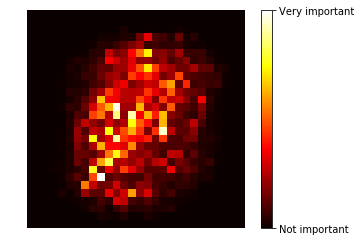

In [36]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# save_fig("mnist_feature_importance_plot")
'''
图7-6：MNIST像素位的重要性（根据随机森林分类器）
'''
plt.show()

提升法
提升法（Boosting，最初被称为假设提升）是指可以将几个弱学
习器结合成一个强学习器的任意集成方法。大多数提升法的总体思路
是循环训练预测器，每一次都对其前序做出一些改正。可用的提升法
有很多，但目前最流行的方法是AdaBoost（http://goo.gl/OIduRW） [1]
（自适应提升法，Adaptive Boosting的缩写）和梯度提升。我们先从
AdaBoost开始介绍。

AdaBoost

新预测器对其前序进行纠正的办法之一，就是更多地关注前序拟
合不足的训练实例。从而使新的预测器不断地越来越专注于难缠的问
题，这就是AdaBoost使用的技术。

例如，要构建一个AdaBoost分类器，首先需要训练一个基础分类
器（比如决策树），用它对训练集进行预测。然后对错误分类的训练
实例增加其相对权重，接着，使用这个最新的权重对第二个分类器进
行训练，然后再次对训练集进行预测，继续更新权重，并不断循环向
前

下面的代码使用Scikit-Learn的AdaBoostClassifier（正如你猜想
的，还有一个AdaBoostRegressor类）训练了一个AdaBoost分类器，它
基于200个单层决策树（decision stump）。顾名思义，单层决策树就
是max_depth=1的决策树，换言之，就是一个决策节点加两个叶节
点。这是AdaBoostClassifier默认使用的基础估算器。

如果你的AdaBoost集成过度拟合训练集，你可以试试减少估
算器数量，或是提高基础估算器的正则化程度。

In [37]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


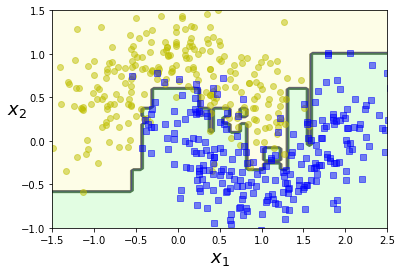

In [38]:
plot_decision_boundary(ada_clf, X, y)


G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
G:\the_NEW_anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


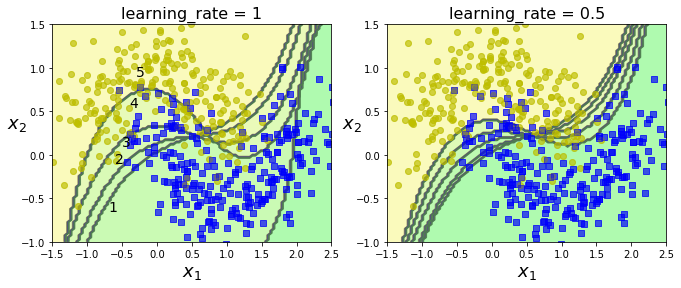

In [39]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
# save_fig("boosting_plot")
'''
图7-8：连续预测器的决策边界

'''
plt.show()

图7-8显示了在卫星数据集上5个连续的预测器的决策边界（在本
例中，每个预测器都是使用RBF核函数的高度正则化的SVM分类
器 [2] ）。第一个分类器产生了许多错误实例，所以这些实例的权重得
到提升。因此第二个分类器在这些实例上的表现有所提升，然后第三
个、第四个……右图绘制的是相同预测器序列，唯一的差别在于学习
率减半（即每次迭代仅提升一半错误分类的实例的权重）。可以看
出，AdaBoost这种依序循环的学习技术跟梯度下降有一些异曲同工之
处，差别只在于——不再是调整单个预测器的参数使成本函数最小
化，而是不断在集成中加入预测器，使模型越来越好。
一旦全部预测器训练完成，集成整体做出预测时就跟bagging或
pasting方法一样了，除非预测器有不同的权重，因为它们总的准确率
是基于加权后的训练集。

这种依序学习技术有一个重要的缺陷就是无法并行（哪怕只
是一部分），因为每个预测器只能在前一个预测器训练完成并评估之
后才能开始训练。因此，在拓展方面，它的表现不如bagging和
pasting方法。

梯度提升
另一个非常受欢迎的提升法是梯度提升（Gradient Boosting）。 [5]
跟AdaBoost一样，梯度提升（http://goo.gl/Ezw4jL）也是逐步在集成
中添加预测器，每一个都对其前序做出改正。不同之处在于，它不是
像AdaBoost那样在每个迭代中调整实例权重，而是让新的预测器针对
前一个预测器的残差进行拟合。

来看一个简单的回归示例，使用决策树作为基础预测器（梯
度提升当然也适用于回归任务），这被称为梯度树提升或者是梯度提
升回归树（GBRT）。首先，在训练集（比如带噪声的二次训练集）
上拟合一个DecisionTreeRegressor：

In [40]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

现在，针对第一个预测器的残差，训练第二个
DecisionTreeRegressor

In [42]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

然后，针对第二个预测器的残差，训练第三个回归器：

In [43]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

现在，我们有了一个包含三棵树的集成。它将所有树的预测相
加，从而对新实例进行预测

In [44]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [45]:
y_pred


array([ 0.75026781])

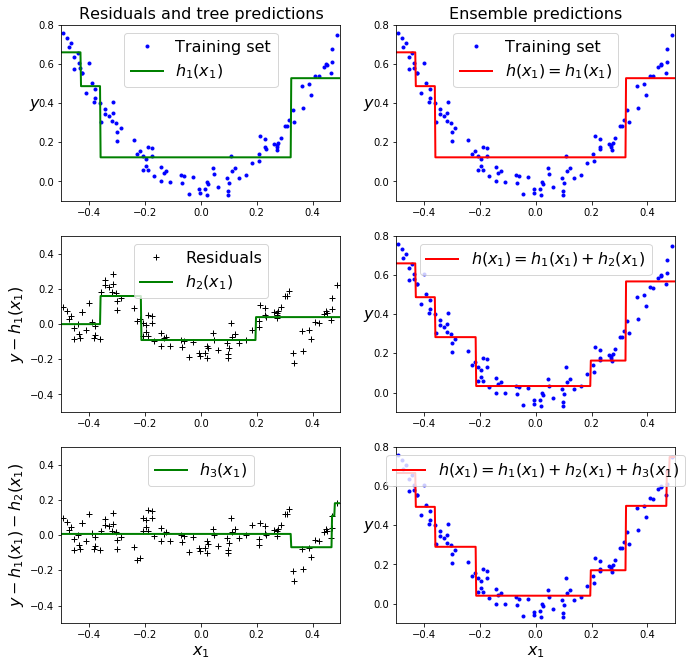

In [46]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")

'''
图7-9：梯度提升
'''


plt.show()

图7-9的左侧表示这三棵树单独的预测，右侧表示集成的预测。
第一行，集成只有一棵树，所以它的预测与第一棵树的预测完全相
同。第二行是在第一棵树的残差上训练的一棵新树，从右侧可见，集
成的预测等于前面两棵树的预测之和。类似地，第三行又有一棵在第
二棵树的残差上训练的新树，集成的预测随着新树的添加逐渐变好。

训练GBRT集成有个简单的方法，就是使用Scikit-Learn的
GradientBoosting-Regressor类。与RandomForestRegressor类似，它具
有控制决策树生长的超参数（例如max_depth、min_samples_leaf
等），以及控制集成训练的超参数，例如树的数量
（n_estimators）。以下代码可创建上面的集成：

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [48]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

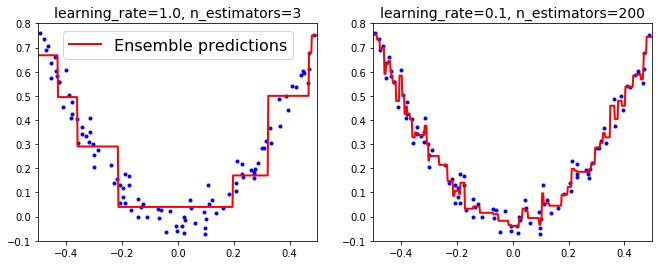

In [49]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

# save_fig("gbrt_learning_rate_plot")
'''
图7-10：GBRT集成——预测器太少（左图）和预测器太多（右图）
'''
plt.show()

超参数learning_rate对每棵树的贡献进行缩放。如果你将其设置
为低值，比如0.1，则需要更多的树来拟合训练集，但是预测的泛化
效果通常更好。这是一种被称为收缩的正则化技术。图7-10显示了用
低学习率训练的两个GBRT集成：左侧拟合训练集的树数量不足，而右侧拟合训练集的树数量过多从而导致过度拟合。

要找到树的最佳数量，可以使用早期停止法（参见第4章）。简
单的实现方法就是使用staged_predict（）方法：它在训练的每个阶段
（一棵树时，两棵树时，等等）都对集成的预测返回一个迭代器。以
下代码训练了一个拥有120棵树的GBRT集成，然后测量每个训练阶
段的验证误差，从而找到树的最优数量，最后使用最优树数重新训练
了一个GBRT集成：

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [51]:
min_error = np.min(errors)


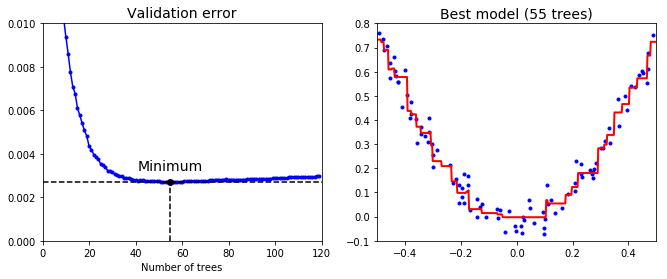

In [52]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

# save_fig("early_stopping_gbrt_plot")
'''
验证误差如图7-11的左图所示，最好的模型预测如右图所示。
'''
plt.show()

实际上，要实现早期停止法，不一定需要先训练大量的树，然后
再回头找最优的数字，还可以真的提前停止训练。设置
warm_start=True，当fit（）方法被调用时，Scikit-Learn会保留现有的
树，从而允许增量训练。以下代码会在验证误差连续5次迭代未改善
时，直接停止训练：

In [53]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

GradientBoostingRegressor类还可以支持超参数subsample，指定
用于训练每棵树的实例的比例。例如，如果subsample=0.25，则每棵
树用25%的随机选择的实例进行训练。现在你可以猜到，这也是用更
高的偏差换取了更低的方差，同时在相当大的程度上加速了训练过程。这种技术被称为随机梯度提升

G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


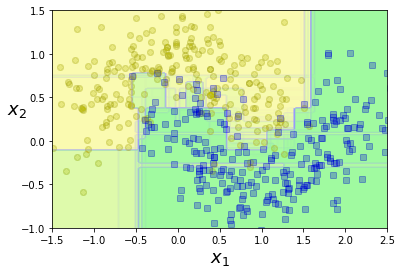

In [30]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()